In [26]:
import pandas as pd
import seaborn as sns
import pylab as plt
import pickle
import wbdata

%matplotlib inline

sns.set(font_scale=1.3)
sns.set_style("white")

In [69]:
name2iso2 = pickle.load(open("./data/name2iso2.dump","rb"))
iso22name = {v: k for k, v in name2iso2.items()}

In [48]:

indicators = {"SE.SEC.TCHR": "Teachers, secondary",
              "SE.PRM.TCHR": "Teachers, primary",
"SH.MED.PHYS.ZS": "Physicians",
             "NY.GDP.MKTP.CD": "GDP",
"SP.POP.TOTL": "Population"}

wbd = wbdata.get_dataframe(indicators, country="all", convert_date=False)
wbd = wbd.reset_index()
wbd["iso2"] = wbd["country"].map(name2iso2)
wbd = wbd.groupby("iso2").mean().reset_index()
wbd["Teachers"] = wbd["Teachers, primary"] + wbd["Teachers, secondary"]
wbd["Physicians"] *= (wbd["Population"]/1000)
del wbd["Teachers, primary"]
del wbd["Teachers, secondary"]
wbd.head()

,iso2,GDP,Physicians,Population,Teachers
0,AD,1.501056e+09,153.241559,5.066674e+04,880.220588
1,AE,1.372487e+11,4087.846373,2.838900e+06,18849.495238
2,AF,6.620578e+09,3173.957079,1.735924e+07,85858.431159
3,AG,7.172131e+08,70.603285,7.621790e+04,1080.197115
4,AL,6.220172e+09,3261.109418,2.703056e+06,34600.000000


## Read data

In [148]:
df = pd.read_csv("data/linkedin_results.csv",sep="\t",header=None,names=["iso2","country","keyword","count"])
df["iso2"] = df["iso2"].str.upper()
professions = pd.pivot_table(df,values="count",index="iso2",columns="keyword").reset_index()
professions = pd.merge(professions,wbd,how="outer")
professions.head()

,iso2,Doctor,Engineer,International tax,Lawyer,Manager,TP advisor,TP analyst,TP consultant,TP counsel,...,Wealth manager,tax analyst,tax consultant,tax lawyer,tax planning,wealth advisor,GDP,Physicians,Population,Teachers
0,AD,20.0,325.0,99.0,59.0,1749.0,0.0,2.0,0.0,0.0,...,76.0,4.0,11.0,7.0,86.0,39.0,1.501056e+09,153.241559,5.066674e+04,880.220588
1,AE,4993.0,259044.0,18871.0,3705.0,NaN,58.0,87.0,5.0,7.0,...,13689.0,588.0,867.0,43.0,21093.0,2731.0,1.372487e+11,4087.846373,2.838900e+06,18849.495238
2,AF,1419.0,8374.0,690.0,288.0,NaN,0.0,0.0,1.0,0.0,...,59.0,19.0,29.0,1.0,633.0,12.0,6.620578e+09,3173.957079,1.735924e+07,85858.431159
3,AG,38.0,318.0,33.0,12.0,2090.0,0.0,0.0,1.0,0.0,...,23.0,5.0,2.0,3.0,58.0,3.0,7.172131e+08,70.603285,7.621790e+04,1080.197115
4,AI,21.0,125.0,16.0,7.0,833.0,0.0,0.0,0.0,0.0,...,8.0,2.0,5.0,0.0,10.0,1.0,NaN,NaN,NaN,NaN


In [151]:
def plot(data,x,y,scale="log"):
    for c,x_,y_ in zip(data["iso2"],data[x],data[y]):
        
        plt.annotate(c,(x_,y_),fontsize=10)
    
    plt.plot(data[x],data[y],".")
    if scale=="log":
        plt.yscale("log")
        plt.xscale("log")
    sns.despine()
    plt.grid()
    plt.xlabel(x)
    plt.ylabel(y)
    


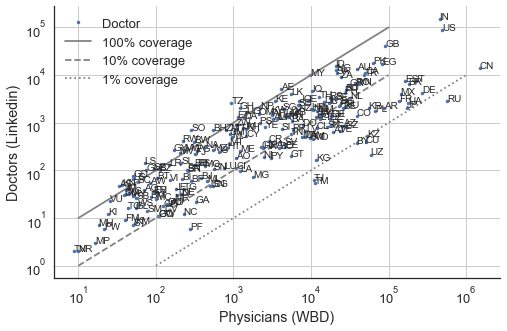

In [159]:
plt.figure(figsize=(8,5))
plot(professions,"Physicians","Doctor")
plt.plot([10,1E5],[10,1E5],color="gray",label="100% coverage")
plt.plot([10,1E5],[1,1E4],"--",color="gray",label="10% coverage")
plt.plot([100,1E6],[1,1E4],":",color="gray",label="1% coverage")
plt.xlabel("Physicians (WBD)")
plt.ylabel("Doctors (Linkedin)")
plt.legend()
plt.show()

In [66]:
professions.columns

Index(['iso2', 'Doctor', 'Engineer', 'International tax', 'Lawyer', 'Manager',
       'TP advisor', 'TP analyst', 'TP consultant', 'TP counsel',
       'TP director', 'TP manager', 'TP partner', 'TP risk management', 'Tax',
       'Tax advisor', 'Tax counsel', 'Tax director', 'Tax manager',
       'Tax partner', 'Tax risk management', 'Teacher', 'Transfer pricing',
       'Wealth management', 'Wealth manager', 'tax analyst', 'tax consultant',
       'tax lawyer', 'tax planning', 'wealth advisor', 'GDP', 'Physicians',
       'Population', 'Teachers'],
      dtype='object')

In [212]:
professions["Tax_doctor"] = professions["Tax"]/professions["Doctor"]
professions["Tax_lawyer"] = professions["Tax"]/professions["Lawyer"]
#professions["Tax_engineer"] = professions["Tax"]/professions["Engineer"]
professions["Wealth manager_doctor"] = professions["Wealth manager"]/professions["Doctor"]
professions["Wealth manager_lawyer"] = professions["Wealth manager"]/professions["Lawyer"]
#professions["Wealth manager_engineer"] = professions["Wealth manager"]/professions["Engineer"]
professions["Transfer pricing_doctor"] = professions["Transfer pricing"]/professions["Doctor"]
professions["Transfer pricing_lawyer"] = professions["Transfer pricing"]/professions["Lawyer"]
#professions["Transfer pricing_engineer"] = professions["Transfer pricing"]/professions["Engineer"]

In [213]:
from sklearn.preprocessing import StandardScaler,RobustScaler

In [288]:
iso22name["DE"] = "Germany"
temp = professions[["iso2"]+[_ for _ in professions.columns if "_" in _]].sort_values(by="Tax_doctor",ascending=False)
temp["country"] = temp["iso2"].map(iso22name)
temp= temp.dropna()
del temp["iso2"]
temp = temp.set_index("country")
temp[:] = StandardScaler().fit_transform(temp[:].values)
temp.head(20)

,Tax_doctor,Wealth manager_doctor,Transfer pricing_doctor,Tax_lawyer,Wealth manager_lawyer,Transfer pricing_lawyer,Lawyers_Doctors
country,,,,,,,
Luxembourg,10.763164,5.912090,12.960415,-0.132589,0.144593,1.255074,7.785937
Gibraltar,4.115304,3.153934,0.826156,0.649208,1.091233,0.065779,1.117385
Guernsey,2.994201,7.618866,0.625859,0.818413,4.568072,0.261431,0.574408
Cayman Islands,2.724248,2.210865,0.840246,0.084709,0.568474,-0.020538,1.319262
Northern Mariana Isl,2.641560,-0.094869,-0.399663,1.571144,-0.185614,-0.866442,0.123687
Bermuda,2.522614,1.601259,1.390422,0.385772,0.621015,0.825367,0.773610
Liechtenstein,2.408426,3.094865,3.413996,0.003261,0.927941,1.765261,1.296969
United States,2.312598,0.532557,0.752727,4.392764,1.621576,3.909862,-0.319618
"Jersey, Channel Islands",2.076189,7.298859,0.371041,0.572785,5.049179,0.101896,0.422702


In [289]:
from sklearn.decomposition import PCA

temp2 = temp.copy()
pca = PCA()
temp2[:] = pca.fit_transform(temp[:].values)
print(pca.explained_variance_ratio_)

[ 0.47121245  0.26232721  0.12420817  0.06286782  0.05049044  0.02015609
  0.00873781]


In [290]:
temp.columns

Index(['Tax_doctor', 'Wealth manager_doctor', 'Transfer pricing_doctor',
       'Tax_lawyer', 'Wealth manager_lawyer', 'Transfer pricing_lawyer',
       'Lawyers_Doctors'],
      dtype='object')

In [291]:
import numpy as np
np.round(pca.components_[:3],1)

array([[ 0.5,  0.5,  0.4,  0.2,  0.3,  0.3,  0.3],
       [ 0.2,  0. ,  0.3, -0.6, -0.4, -0.4,  0.5],
       [-0.1,  0.5, -0.3, -0.2,  0.5, -0.5, -0.1]])

In [292]:
temp2.columns = list(range(temp2.shape[1]))

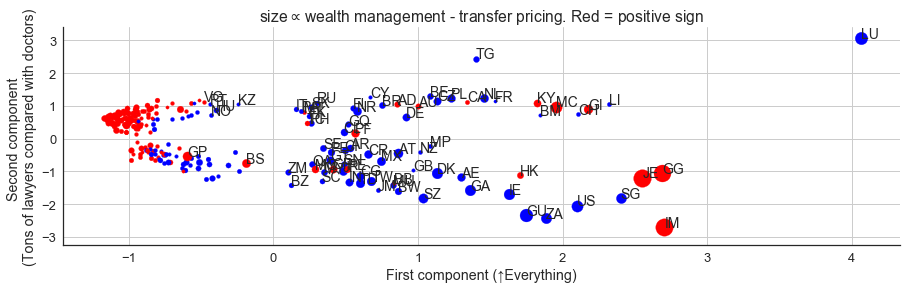

In [302]:
temp2["iso2"] = [name2iso2[_] for _ in temp2.index]
data = temp2.copy()
data[0] = np.sign(data[0])*np.sqrt(np.abs(data[0]))
data[1] = np.sign(data[1])*np.sqrt(np.abs(data[1]))

plt.figure(figsize=(15,4))
for c,x_,y_,s_ in zip(data["iso2"],data[0],data[1],data[2]):
    if ((x_>-0.5) & (x_<0) & (y_>0)):
        plt.annotate(c,(x_,y_),fontsize=14)
    elif s_>1:
        plt.annotate(c,(x_,y_),fontsize=14)
    elif x_>0:
        plt.annotate(c,(x_,y_),fontsize=14)
    if s_<0:
        color = "blue"
    else:
        color = "red"
    plt.scatter(x_,y_,s=10+50*np.abs(s_),color=color)

sns.despine()
plt.grid()

    
plt.xlabel("First component (↑Everything)")
plt.ylabel("Second component \n(Tons of lawyers compared with doctors)")
plt.title(r"size$\propto$wealth management - transfer pricing. Red = positive sign")


In [295]:
data.loc[iso22name["VG"]].reset_index()

,index,"Virgin Islands, British"
0,0,-0.482929
1,1,1.13411
2,2,0.105219
3,3,0.732797
4,4,-0.0443748
5,5,-0.0597082
6,6,0.420585
7,iso2,VG
